In [1]:
import math

import numpy as np
from pathlib import Path
import os, json, subprocess, re, math
from typing import List, Dict, Iterator, Pattern, Any, Tuple
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

### Helpers

In [2]:
def period_lambda(pl: float):
    return 86400 / pl

msgs_per_day = [3, 10, 50, 100, 400]

periods = list(map(period_lambda, msgs_per_day))
print(periods)

def half_circle_eq(center: Tuple[float, float], radius: float, n: int) -> Tuple:
    _t = np.linspace(np.pi, 2*np.pi, n)  # (0, np.pi) for top half
    _x = center[0] + radius * np.cos(_t)
    _y = center[1] + radius * np.sin(_t)
    return _x, _y

[28800.0, 8640.0, 1728.0, 864.0, 216.0]


### Populate data

In [3]:
MAIN_SCRIPT = "./run_main.sh"
CONFIG_FILE = "config.json"

base_dir = Path.cwd()
cfg_path = base_dir / CONFIG_FILE
if not cfg_path.exists():
    raise FileNotFoundError(f"Config file not found: {cfg_path}")
try:
    cfg = json.loads(cfg_path.read_text(encoding="utf-8"))
except json.JSONDecodeError as e:
    raise ValueError(f"Invalid JSON in {cfg_path}: {e}") from e

populate = False

def populate_from_config(runner: str = MAIN_SCRIPT, dry_run: bool = False) -> None:
    desert_env = cfg.get("desert_env")
    rounds = cfg.get("rng_rounds", 1)
    start_rng = cfg.get("rng_start", 1)
    comb: Dict[str, List] = cfg.get("combine", {})
    iterations: List[Dict[str, Any]] = cfg.get("iterations", [])

    print(f"Loaded: rng_rounds={rounds}, rng_start={start_rng}, entries={len(iterations)}")

    cmds: List[str] = []
    if desert_env:
        env_file = (base_dir / desert_env).resolve()
        if not env_file.exists():
            raise FileNotFoundError(f"desert_env file not found: {env_file}")
        # Source environment first
        cmds.append(f"source '{env_file}'")

    if "nn" not in comb:
        comb["nn"] = [0]

    if "period" not in comb:
        comb["period"] = [0]

    if "sink_mode" not in comb:
        comb["sink_mode"] = [0]

    for nn_param in comb["nn"]:
        for period_param in comb["period"]:
            for sink_mode_param in comb["sink_mode"]:
                entry = {
                    "nn": nn_param,
                    "period": period_param,
                    "sink_mode": sink_mode_param
                }
                iterations.append(entry)


    for i, it in enumerate(iterations):
        if not isinstance(it, dict):
            raise ValueError(f"iterations[{i}] must be an object, got {type(it).__name__}")
        nn = it.get("nn")
        period = it.get("period")
        sink_mode = it.get("sink_mode")
        cmds.append(f"{runner} {nn} {period} {sink_mode} {rounds} {start_rng}")

    sep = " && "
    full_cmd = sep.join(cmds)

    if dry_run:
        print("DRY_RUN chained command:\n", full_cmd)
        return

    print("Executing bash command...")
    print(full_cmd)
    completed = subprocess.run(["bash", "-c", full_cmd], cwd=base_dir)
    if completed.returncode != 0:
        raise RuntimeError(f"Chained command failed with exit code {completed.returncode}")
    print("Success!")

if populate:
    populate_from_config()



### Reading trace data, parsing functions

In [4]:
sink_id_dict = {
    "0": 254,
    "1": 253,
    "2": 252
}

def parse_file_records(regex: Pattern, path: str) -> Iterator[Dict]:
    """Yield one dict per matching log line from `path`."""
    with open(path, "r") as f:
        for line in f:
            m = regex.match(line)
            if not m:
                continue

            sink_id = sink_id_dict[m.group("sink_id")] if m.group("sink_id") in sink_id_dict else m.group("sink_id")
            yield {
                "time": float(m.group("time")),
                "sink_id": int(sink_id),
                "packet_id": int(m.group("packet_id")),
                "src_ip": int(m.group("src_ip")),
            }

In [5]:
def iteration_results(sink_log_path: str, node_log_path: str) -> Tuple:
    _pattern = re.compile(r"\[(?P<time>\d+(?:\.\d+)?)\]::DBG::UWUDP\((?P<sink_id>\d+)\)::recv\(Packet \*, int\)::new packet with id (?P<packet_id>\d+) from ip (?P<src_ip>\d+) : \d+")

    sink_df = df.from_records(parse_file_records(_pattern, sink_log_path))
    node_df = pd.read_csv(node_log_path, skiprows=17, header=0)
    node_df = node_df.replace("_", np.nan).infer_objects(copy=False)
    if verbose:
        if parts[0] == 1 and parts[1] == 28800:
            # print("Parsed rows:", len(udp_df))
            print(node_df.head())
            print(sink_df.head())

    summary = df()
    if not sink_df.empty:
        summary = sink_df.groupby("packet_id") \
            .agg(first_time=("time", "min"), last_time=("time", "max"), duplicates=("packet_id", "count"), sinks=("sink_id", lambda s: sorted(set(s)))) \
            .reset_index()

        if verbose:
            if parts[0] == 1 and parts[1] == 28800:
                print(summary.head())
    else:
        print(f"Warning: No matching UDP recv lines found in {sink_log_path}.")


    total_recv = len(summary)
    total_sent = node_df["n_pkts"].sum()
    total_pdr = (total_recv / total_sent * 100) if total_sent > 0 else 100.0

    if verbose:
        if parts[0] == 1 and parts[1] == 28800:
            print("Total received packets:", total_recv)
            print("Total transmitted packets: ", total_sent)
            print(f"Total PDR: {total_pdr:.2f}")
    return node_df, sink_df, total_pdr

### Preparing data

In [6]:
DATA_PATH = "data/"
EXPERIMENT_ITER = cfg["rng_rounds"]

verbose = False
nodes_target = [50, 216.0, 3, 10]
nodes = df()
results_rows = []
for experiment_dir in os.listdir(DATA_PATH):
    subdir_path = os.path.join(DATA_PATH, experiment_dir)
    if os.path.isdir(subdir_path):
        parts = experiment_dir.split('_')
        parts[0] = int(parts[0])
        parts[1] = float(parts[1])
        parts[2] = int(parts[2])

        if verbose:
            if parts[0] == 1 and parts[1] == 28800:
                print(parts)
        for i in range(1, EXPERIMENT_ITER + 1):
            sink_path = os.path.join(subdir_path, f"{experiment_dir}_{i}_sink.out")
            node_path = os.path.join(subdir_path, f"{experiment_dir}_{i}_node.out")
            n_df, _, pdr = iteration_results(sink_path, node_path)
            if parts[0] == nodes_target[0] and parts[1] == nodes_target[1] and parts[2] == nodes_target[2] and i == nodes_target[3]:
                nodes = n_df

            if verbose:
                if parts[0] == 1 and parts[1] == 28800:
                    print(i, pdr)

            results_rows.append({
                "nn": parts[0],
                "period": parts[1],
                "sink_mode": parts[2],
                "rng": int(i),
                "total_pdr": float(pdr)
            })

C:\Users\user\AppData\Local\Temp\ipykernel_5500\2797978730.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  node_df = node_df.replace("_", np.nan).infer_objects(copy=False)
C:\Users\user\AppData\Local\Temp\ipykernel_5500\2797978730.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  node_df = node_df.replace("_", np.nan).infer_objects(copy=False)
C:\Users\user\AppData\Local\Temp\ipykernel_5500\2797978730.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the o

C:\Users\user\AppData\Local\Temp\ipykernel_5500\2797978730.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  node_df = node_df.replace("_", np.nan).infer_objects(copy=False)
C:\Users\user\AppData\Local\Temp\ipykernel_5500\2797978730.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  node_df = node_df.replace("_", np.nan).infer_objects(copy=False)
C:\Users\user\AppData\Local\Temp\ipykernel_5500\2797978730.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the o

C:\Users\user\AppData\Local\Temp\ipykernel_5500\2797978730.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  node_df = node_df.replace("_", np.nan).infer_objects(copy=False)
C:\Users\user\AppData\Local\Temp\ipykernel_5500\2797978730.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  node_df = node_df.replace("_", np.nan).infer_objects(copy=False)
C:\Users\user\AppData\Local\Temp\ipykernel_5500\2797978730.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the o

### Extracting results

In [7]:
results_df = df(results_rows)

results_df = results_df.groupby(["nn", "period", "sink_mode"]).agg(
    pdr_count=("total_pdr", "count"),
    pdr_mean=("total_pdr", "mean"),
    pdr_std=("total_pdr", "std"),
    pdr_min=("total_pdr", "min"),
    pdr_q25=("total_pdr", lambda x: x.quantile(0.25)),
    pdr_median=("total_pdr", "median"),
    pdr_q75=("total_pdr", lambda x: x.quantile(0.75)),
    pdr_max=("total_pdr", "max"),
).reset_index()

results_df["lambda"] = results_df["period"].apply(period_lambda)
print(results_df.head(100))

     nn   period  sink_mode  pdr_count    pdr_mean    pdr_std     pdr_min  \
0     1    216.0          1         20   96.737995   4.791948   86.374696   
1     1    216.0          3         20  100.000000   0.000000  100.000000   
2     1    864.0          1         20   96.791807   4.718522   87.356322   
3     1    864.0          3         20  100.000000   0.000000  100.000000   
4     1   1728.0          1         20   96.937835   4.837666   85.365854   
5     1   1728.0          3         20  100.000000   0.000000  100.000000   
6     1   8640.0          1         20   98.087607   5.376842   77.777778   
7     1   8640.0          3         20  100.000000   0.000000  100.000000   
8     1  28800.0          1         20   97.500000  11.180340   50.000000   
9     1  28800.0          3         20  100.000000   0.000000  100.000000   
10   10    216.0          1         20   89.808066   1.692548   86.105627   
11   10    216.0          3         20   95.441305   0.465293   93.997599   

In [8]:
# pivot so each sink_mode is a column
pivot = results_df.pivot_table(
    index=["nn", "lambda"],
    columns="sink_mode",
    values=["pdr_mean", "pdr_std"],
    aggfunc="mean"
).reset_index()

pdr_1 = pivot["pdr_mean"].get(1)
pdr_3 = pivot["pdr_mean"].get(3)



pivot["pdr_gain_abs"] = (pdr_3 - pdr_1).abs()
pivot["pdr_gain_percent"] = (pdr_3 - pdr_1) / pdr_1 * 100

print(pivot.head(100))

            nn lambda   pdr_mean                pdr_std            \
sink_mode                      1           3          1         3   
0            1    3.0  97.500000  100.000000  11.180340  0.000000   
1            1   10.0  98.087607  100.000000   5.376842  0.000000   
2            1   50.0  96.937835  100.000000   4.837666  0.000000   
3            1  100.0  96.791807  100.000000   4.718522  0.000000   
4            1  400.0  96.737995  100.000000   4.791948  0.000000   
5           10    3.0  97.445257  100.000000   2.684733  0.000000   
6           10   10.0  96.218840  100.000000   2.019567  0.000000   
7           10   50.0  95.918748   99.552797   2.249106  0.438924   
8           10  100.0  94.702665   98.780495   1.516945  0.456877   
9           10  400.0  89.808066   95.441305   1.692548  0.465293   
10          20    3.0  97.267443  100.000000   2.408245  0.000000   
11          20   10.0  96.771720   99.771122   1.981216  0.389924   
12          20   50.0  94.693225  

### Plotting

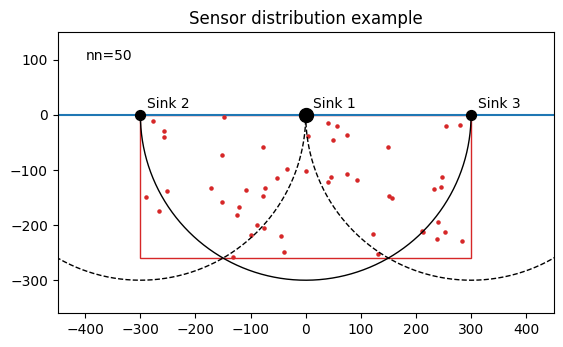

In [9]:
max_range = 300.0
n = 400
xlim_scale = 1.5
ylim_scale = 1.2

surface_x = np.linspace(-max_range*xlim_scale, max_range*xlim_scale, n)
surface_y = [0] * len(surface_x)
main_sink_x = [0.0]
main_sink_y = [0.0]
side_sink_x = [-max_range, max_range]
side_sink_y = [0.0, 0.0]
sink_x, sink_y = main_sink_x + side_sink_x, main_sink_y + side_sink_y
sink_label = ["Sink 1", "Sink 2", "Sink 3"]
sink1_x, sink1_y = half_circle_eq((0.0, 0.0), max_range, n)
sink2_x, sink2_y = half_circle_eq((-max_range, 0.0), max_range, n)
sink3_x, sink3_y = half_circle_eq((max_range, 0.0), max_range, n)
zone_x0, zone_y0 = -max_range, -math.sqrt(3)*max_range/2
zone_w, zone_h = 2*max_range, abs(zone_y0)

fig, ax = plt.subplots()
ax.plot(surface_x, surface_y, zorder=-1)
ax.plot(sink1_x, sink1_y, linewidth=1, linestyle="-" ,color="black")
ax.plot(sink2_x, sink2_y, linewidth=1, linestyle="--",color="black")
ax.plot(sink3_x, sink3_y, linewidth=1, linestyle="--",color="black")
rect_outline = Rectangle((zone_x0, zone_y0), zone_w, zone_h, fill=False, edgecolor="tab:red", linewidth=1, zorder=-2)
ax.add_patch(rect_outline)

ax.scatter(main_sink_x, main_sink_y, s=100, color="black")
ax.scatter(side_sink_x, side_sink_y, s=50, color="black")
for i, label in enumerate(sink_label):
    ax.annotate(label, (sink_x[i], sink_y[i]), textcoords="offset points", xytext=(5,5), ha='left')

ax.annotate(f"nn={nodes_target[0]}", (-400, 100))
nodes["y"] = -nodes["y"].abs()
ax.scatter(nodes["x"], nodes["y"], s=5, color="tab:red")

ax.set_xlim(-max_range*xlim_scale, max_range*xlim_scale)
ax.set_ylim(-max_range*ylim_scale, 150)
ax.set_aspect("equal", adjustable="box")
plt.title("Sensor distribution example")
plt.savefig("data/distribution.png")
plt.show()

   nn   period  sink_mode  pdr_count   pdr_mean    pdr_std    pdr_min  \
0   1    216.0          1         20  96.737995   4.791948  86.374696   
2   1    864.0          1         20  96.791807   4.718522  87.356322   
4   1   1728.0          1         20  96.937835   4.837666  85.365854   
6   1   8640.0          1         20  98.087607   5.376842  77.777778   
8   1  28800.0          1         20  97.500000  11.180340  50.000000   

      pdr_q25  pdr_median     pdr_q75  pdr_max  lambda  
0   96.404011   99.221293   99.755319    100.0   400.0  
2   96.107332   99.060847  100.000000    100.0   100.0  
4   96.628788  100.000000  100.000000    100.0    50.0  
6  100.000000  100.000000  100.000000    100.0    10.0  
8  100.000000  100.000000  100.000000    100.0     3.0  
   nn   period  sink_mode  pdr_count  pdr_mean  pdr_std  pdr_min  pdr_q25  \
1   1    216.0          3         20     100.0      0.0    100.0    100.0   
3   1    864.0          3         20     100.0      0.0    100.0 

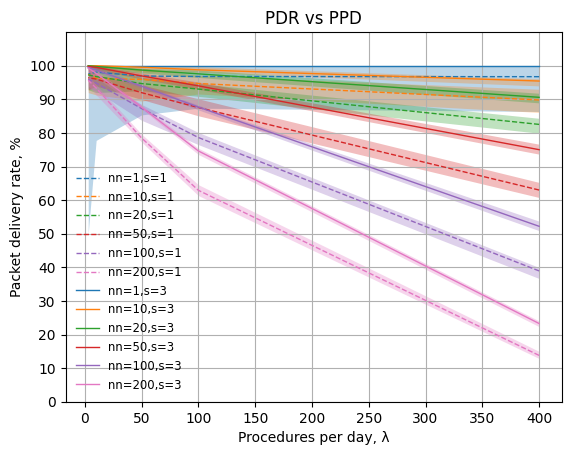

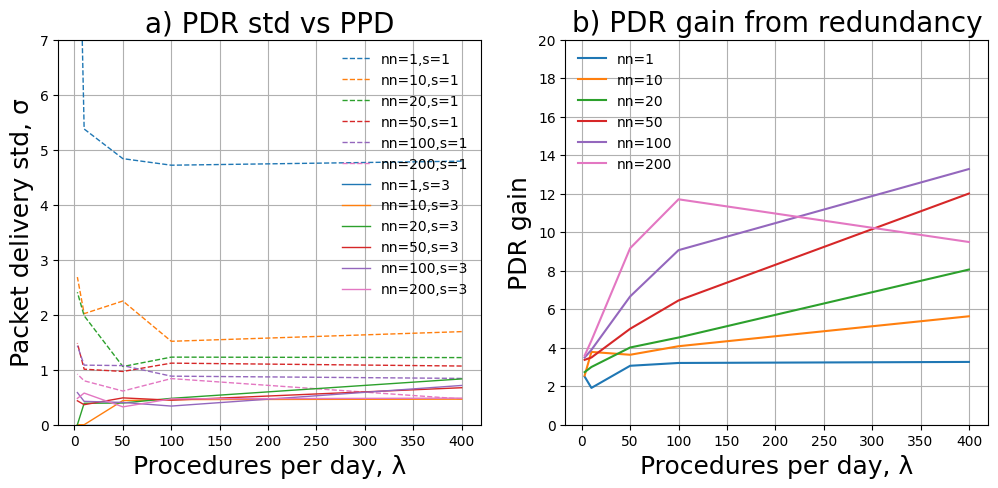

In [10]:
results_sink_1_df = results_df[results_df["sink_mode"] == 1]
print(results_sink_1_df.head())
results_sink_3_df = results_df[results_df["sink_mode"] == 3]
print(results_sink_3_df.head())

nn_colors = {
    1:      "tab:blue",
    10:     "tab:orange",
    20:     "tab:green",
    50:     "tab:red",
    100:    "tab:purple",
    200:    "tab:pink"
}

plot_data = [
    {
        "linestyle": "--",
        "sink": 1,
        "df": results_sink_1_df
    },
    {
        "linestyle": "-",
        "sink": 3,
        "df": results_sink_3_df
    }
]

for plot in plot_data:
    for nn in plot["df"]["nn"].unique():
        curr = plot["df"][plot["df"]["nn"] == nn]
        color = nn_colors[nn]
        plt.plot(curr["lambda"], curr["pdr_mean"], color=color, linestyle=plot["linestyle"], linewidth=1, label=f"nn={nn},s={plot['sink']}")
        plt.fill_between(curr["lambda"], curr["pdr_min"], curr["pdr_max"], color=color, alpha=0.3, linewidth=0)

plt.ylim(0.0, 110.0)
plt.yticks(range(0, 101, 10))
plt.xlabel("Procedures per day, λ")
plt.ylabel("Packet delivery rate, %")
plt.legend(fontsize="small", framealpha=0)
plt.title("PDR vs PPD")
plt.grid(True)
plt.savefig("data/pdr_pdd.png")
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

for plot in plot_data:
    for nn in plot["df"]["nn"].unique():
        curr = plot["df"][plot["df"]["nn"] == nn]
        color = nn_colors[nn]
        ax1.plot(curr["lambda"], curr["pdr_std"], color=color, linestyle=plot["linestyle"], linewidth=1, label=f"nn={nn},s={plot['sink']}")

ax1.set_ylim(0.0, 7.0)
ax1.set_yticks(range(0, 8, 1))
ax1.set_xlabel("Procedures per day, λ", fontsize=18)
ax1.set_ylabel("Packet delivery std, σ", fontsize=18)
ax1.legend(loc="upper right", fontsize=10, framealpha=0)
ax1.set_title("a) PDR std vs PPD", fontsize=20)
ax1.grid(True)

for nn in pivot["nn"].unique():
    curr = pivot[pivot["nn"] == nn]
    ax2.plot(curr["lambda"], curr["pdr_gain_abs"], color=nn_colors[nn], label=f"nn={nn}")

ax2.set_ylim(0.0, 20.0)
ax2.set_yticks(range(0, 21, 2))
ax2.set_xlabel("Procedures per day, λ", fontsize=18)
ax2.set_ylabel("PDR gain", fontsize=18)
ax2.legend(framealpha=0)
ax2.set_title("b) PDR gain from redundancy", fontsize=20)
ax2.grid(True)
plt.savefig("data/std_pdr_gain.png")
plt.show()